<a href="https://colab.research.google.com/github/AkshitAggarwal/TSAI_EVA5B2_Phase1/blob/main/Session_05/S5_Assignment_Step3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Call all necessary libraries. 

 Only call libraries and dependencies which are used in the notebook, because each library takes up additional memory. 
  

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy 

### 2. Create data transform compose. 

Use the compose function from `torch.transforms` to compile all necessarry data transformations that you want to apply to your datasets in one place. 

In [2]:
train_transforms = transforms.Compose([
                                      # transforms.RandomRotation(degrees=(-7, 7), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])
test_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                    ])

### 3. Create datasets. 

Create your `train`, `validate`, `test` datasets and apply the transforms that were created above using compose. 

In [3]:
train_dataset = datasets.MNIST(root='./data', train = True, transform = train_transforms, download = True)
test_dataset = datasets.MNIST(root='./data', train = False, transform = test_transforms, download = True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 4. Create dataloaders. 

Create dataloaders for respective datasets. Dataloaders are iterable objects that can be fed to the model in smaller, randomized batches to avoid overfitting. 

In [4]:
SEED = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu") #Assigns device based on availability

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#Arguments to be fed into dataloaders. 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

##Train and Test dataloaders. 
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

### 5. Data statistics.

Check all necessary data statistics, such as min, max, std, mean values of the dataset. 

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


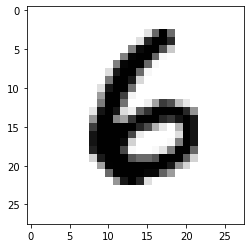

In [5]:
train_data = train_dataset.train_data
train_data = train_dataset.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_dataset.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_dataset.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

### 6. Visualize dataset. 

Take a look at a few images of the training dataset. It gives you an idea of what you're dealing with. By looking at the dataset examples you can determine how difficult your task can be and what kind of transformations may help your model predict better. 

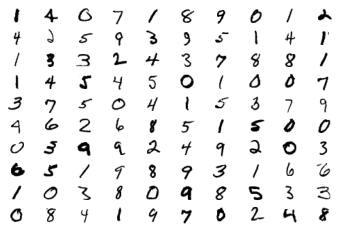

In [6]:
figure = plt.figure()
num_of_images = 100
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### 7. Define model architecture. 

Create your model class and define model architecture. Keep in mind things like 


1. Model complexity
2. Number of layers
3. Parameters
4. Padding in Conv Layers
5. Kernel size
6. Receptive field



In [16]:
class Net(nn.Module):
    #Constructor function initializes an object of Net() and defines all the layers. 
    #Each layer is defined here separately and aren't connected to each other in any way yet. 
    def __init__(self):
        super(Net, self).__init__()
        self.convBlock1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, bias = False), #in_channel: 1,28,28; out_channel: 8,26,26; RF: 3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1)
        )  
        self.convBlock2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, bias = False), #in_channel: 8,26,26; out_channel: 8,24,24; RF: 5
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1)
        )
        self.pool1 = nn.MaxPool2d(2, 2) #in_channel: 8,24,24; out_channel: 8,12,12; RF: 10
        self.convBlock3 = nn.Sequential(
            nn.Conv2d(8, 16, 3, bias = False), #in_channel: 8,12,12; out_channel: 16,10,10; RF: 12
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        )
        self.convBlock4 = nn.Sequential(
            nn.Conv2d(16, 16, 3, bias = False), #in_channel: 16,10,10; out_channel: 16,8,8; RF: 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        )
        self.convBlock5 = nn.Sequential(
            nn.Conv2d(16, 32, 3, bias = False), #in_channel: 16,8,8; out_channel: 32,6,6; RF: 16
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1)
        )
        self.gap = nn.AvgPool2d((6, 6)) #in_channel: 10,6,6; out_channel: 10,1,1; RF: ?
        self.convBlock6 = nn.Conv2d(32, 10, 1, bias = False) #in_channel: 20,1,1; out_channel: 10,1,1; 

    #Forward function takes an object and it passes through each layer sequentially. 
    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.pool1(x)
        x = self.convBlock3(x)
        x = self.convBlock4(x)
        x = self.convBlock5(x)
        x = self.gap(x)
        x = self.convBlock6(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim = -1)

### 8. Look at model summary. 

Use `torchsummary` to look at model summary, load the model on gpu if available. 

In [17]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device) #Converts our model into the respective device.
summary(model, input_size=(1, 28, 28)) #Prints the summary of our model based on an input size.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,152
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

### 9. Define Train and Test functions

In [18]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_samples = len(train_loader.dataset)
test_samples = len(test_loader.dataset)
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    total_correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device) #Loading the images and targets on the GPU
        optimizer.zero_grad() 
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss #Calculating the total loss for the epoch. 
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        total_correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_accuracies.append(100. * total_correct / processed)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} accuracy={100. * total_correct/processed:0.2f}')
    


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    processed = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(100. * correct / processed)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)'.format(
        test_loss, correct, test_samples,
        100. * correct / processed))

### 10. Define optimizer and train the model. 

Train the model for n epochs. 

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


loss=0.15745095908641815 batch_id=468 accuracy=88.00: 100%|██████████| 469/469 [00:12<00:00, 36.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1010, Accuracy: 9728/10000 (97.2800%)
EPOCH: 1


loss=0.1219373568892479 batch_id=468 accuracy=97.58: 100%|██████████| 469/469 [00:13<00:00, 36.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0677, Accuracy: 9806/10000 (98.0600%)
EPOCH: 2


loss=0.09883757680654526 batch_id=468 accuracy=98.12: 100%|██████████| 469/469 [00:12<00:00, 36.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9873/10000 (98.7300%)
EPOCH: 3


loss=0.07433435320854187 batch_id=468 accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 36.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9859/10000 (98.5900%)
EPOCH: 4


loss=0.04234643653035164 batch_id=468 accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9891/10000 (98.9100%)
EPOCH: 5


loss=0.033292751759290695 batch_id=468 accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9886/10000 (98.8600%)
EPOCH: 6


loss=0.04224880039691925 batch_id=468 accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9900/10000 (99.0000%)
EPOCH: 7


loss=0.016447992995381355 batch_id=468 accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9920/10000 (99.2000%)
EPOCH: 8


loss=0.012667777948081493 batch_id=468 accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9909/10000 (99.0900%)
EPOCH: 9


loss=0.03143113851547241 batch_id=468 accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 35.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9909/10000 (99.0900%)
EPOCH: 10


loss=0.053147222846746445 batch_id=468 accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9909/10000 (99.0900%)
EPOCH: 11


loss=0.01113275159150362 batch_id=468 accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.1600%)
EPOCH: 12


loss=0.05366331338882446 batch_id=468 accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9906/10000 (99.0600%)
EPOCH: 13


loss=0.011012514121830463 batch_id=468 accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.2200%)
EPOCH: 14


loss=0.015053949318826199 batch_id=468 accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9911/10000 (99.1100%)
EPOCH: 15


loss=0.016436150297522545 batch_id=468 accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.2100%)
EPOCH: 16


loss=0.020364845171570778 batch_id=468 accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9925/10000 (99.2500%)
EPOCH: 17


loss=0.064792700111866 batch_id=468 accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9925/10000 (99.2500%)
EPOCH: 18


loss=0.08022775501012802 batch_id=468 accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.2900%)
EPOCH: 19


loss=0.024214820936322212 batch_id=468 accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]



Test set: Average loss: 0.0232, Accuracy: 9926/10000 (99.2600%)


### 11. Visualize model performance

Use matplotlib to plot the model summary to directly compare results. 

Text(0.5, 1.0, 'Test Accuracy')

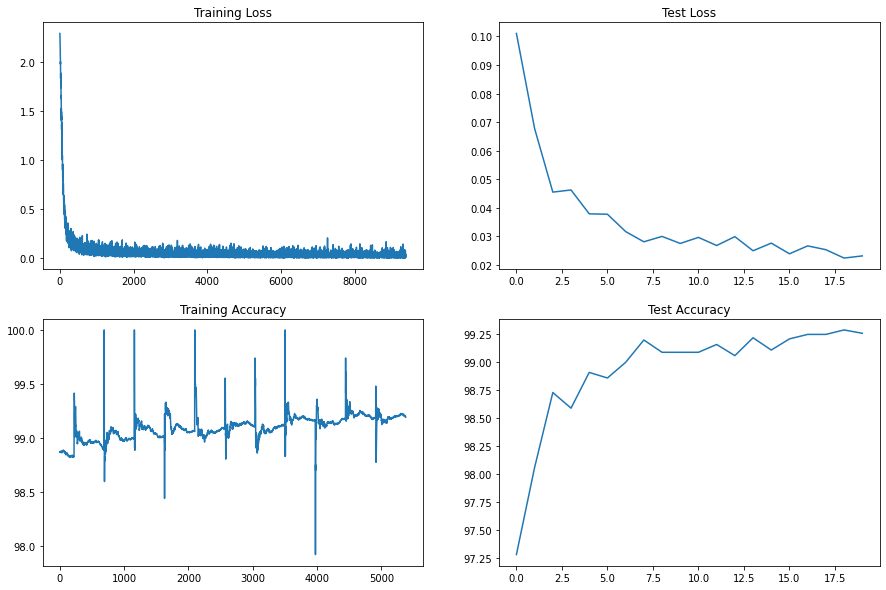

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")